# Generative Adversarial Networks (GANs) - An A-Z tutorial

## Table of Contents

1. [Introduction](#introduction)
2. [Background and Theory](#section2)
3. [Setting up the Environment](#section3)
4. [Dataset Introduction and Preparation](#section4)
5. [Implementing a Basic GAN](#section5)
6. [Training the GAN](#section6)
7. [Limitations of GANs](#section7)
8. [Summary and Conclusion](#section8)
9. [Exercises and Challenges](#section9)

## <a name='introduction'>Introduction</a>

GANs are one of the most exciting advancements in machine learning in recent years. They have shown remarkable results in a variety of applications such as image synthesis, super-resolution, and image-to-image translation.

This notebook aims to introduce you to the fundamental concepts of GANs, guide you through the necessary steps to grasp the GAN framework, and provide hands-on experience with the implementation of a GAN model. By the end of this guide, you will understand:

- What GANs are and the theory behind them.
- How to implement a basic GAN model.
- How to train a GAN model.
- The limitations and challenges of GANs.

This guide is designed to be informative. It is to get you up to speed very quickly with how GANs work, not to challenge you to implement one yourself. This notebook covers the basics, but I encourage you to look at all the interesting follow-up work and see what is out there for yourself.

## 2. Background and Theory <a class='anchor' id='section2'></a>

GANs, short for Generative Adversarial Networks, are a class of machine learning frameworks introduced by [Ian Goodfellow and his colleagues in 2014](https://papers.nips.cc/paper_files/paper/2014/hash/5ca3e9b122f61f8f06494c97b1afccf3-Abstract.html). They are designed to generate new, synthetic instances of data that can pass for real, existing instances.

### 2.1 Fundamental Concepts

GANs consist of two parts:

**Generator:** This is the "counterfeiter," tasked with creating fake data. The generator takes random noise as input and generates data (e.g., an image) as output.

**Discriminator:** This is the "police," trying to distinguish the fake data from real data. It is a binary classifier that outputs the probability that the given input comes from the real dataset rather than the generator.

### 2.2 Architecture of GANs

The generator and discriminator are set up to play a two-player minimax game, in which the generator tries to fool the discriminator, and the discriminator tries to not get fooled. This process can be summarized as follows:

1. The generator creates a batch of fake data.
2. The fake data, along with real data, are given to the discriminator.
3. The discriminator classifies the data as real or fake.
4. Both the generator and discriminator learn from their mistakes and adjust for the next round.

This adversarial process leads the generator to produce increasingly realistic data, while the discriminator becomes better at distinguishing fake data. Over time, the generator can produce data that's almost indistinguishable from the real data.

### 2.3 Understanding the Loss Function

The loss function of a GAN reflects the adversarial relationship between the generator and the discriminator. The generator aims to minimize this function, while the discriminator aims to maximize it. This is the essence of the minimax game played between the two.

Mathematically, the value function $V$ for a simple GAN can be written as:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_z(z)}[\log(1-D(G(z)))]$$

where:
- `G` is the generator function, which maps from the latent space to the feature (data) space.
- `D` is the discriminator function, which outputs the probability that the data came from the real dataset.
- `z` is a random prior, a point in the latent space, which is the input that the generator uses to generate a fake sample.
- `x` is a point in the feature (data) space.

The first term in the equation is the expectation of the log-probability that the discriminator correctly classifies a real instance as real. The second term is the expectation of the log-probability that the discriminator correctly classifies a fake (generated) instance as fake.

As the generator's goal is to fool the discriminator, it tries to maximize the probability that the discriminator incorrectly classifies a fake instance as real, hence it aims to minimize `log(1 - D(G(z)))`. On the other hand, the discriminator tries to correctly classify both real and fake instances, hence it aims to maximize both `log(D(x))` and `log(1 - D(G(z)))`.

In practice, the generator minimizes the negative of this loss function, which is equivalent to maximizing the probability that the discriminator incorrectly classifies a fake instance as real.

Through this process, both the generator and the discriminator improve their ability to generate realistic data and distinguish between real and fake data, respectively.

## 3. Setting up the Environment <a class='anchor' id='section3'></a>

Now that you have a rough understanding of how GANs work, let's implement them. For the implementation, we need a couple of libraries.

In [2]:
!pip install numpy matplotlib torch torchvision tqdm

In [25]:
# Check if everything is downloaded correctly
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets
from tqdm import tqdm

print("Loaded all libraries successfully!")

Loaded all libraries successfully!


## 4. Dataset Introduction and Preparation <a class='anchor' id='section4'></a>

We will be using the MNIST dataset throughout this notebook. This dataset is easily accessible through the torchvision library.

In [5]:
# Download the MNIST dataset.
mnist_dataset = datasets.MNIST(root='./.data/mnist_data/', train=True, download=True)

Dataset shape:  torch.Size([60000, 28, 28])


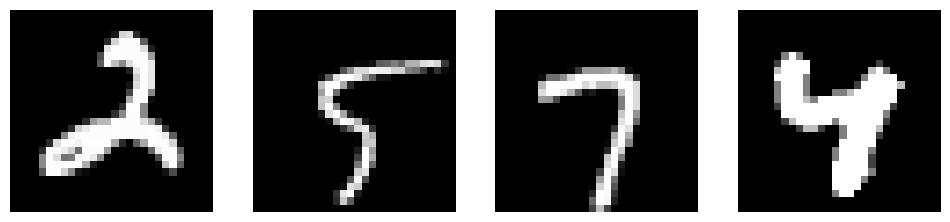

In [16]:
# The training data consists of 60.000 samples, each of 28 by 28 pixels.
print("Dataset shape: ", mnist_dataset.data.shape)

def plot_5(batch):
    indices = np.random.choice(batch.shape[0], size=4, replace=False)

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    for i, idx in enumerate(indices):
        image = batch[idx]
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')

    plt.show()

plot_5(mnist_dataset.data)

### 4.1 Preprocessing

Before we can use the MNIST dataset for training our GAN, we need to preprocess the images. This preprocessing involves three main steps: casting the images to floats, normalizing the images and reshaping them into 1D tensors.

**Casting:** By default, the MNIST data consists of integers. Before we can normalize the data, we need to turn the datatype into floats.

**Normalization:** The pixel intensities in the MNIST images are originally in the range of 0 to 255. We normalize these intensities to be in the range [-1, 1]. Normalization helps to stabilize the training process and makes the output of the generator easier to interpret.

**Reshaping:** Since we are going to use a simple GAN with multi-layer perceptrons, we need to flatten each image, which is originally a 2D tensor (28x28), into a 1D tensor (of size 784). This is because multi-layer perceptrons accept input data in a flat, vectorized form.

In [26]:
from torchvision.transforms import Normalize


def preprocess_dataset(dataset):
    # Casting
    dataset = dataset.float()

    # Normalization
    dataset = Normalize(0.5, 0.5)(dataset)

    # Reshaping
    dataset = dataset.reshape(dataset.shape[0], -1)

    return dataset

preprocessed_dataset = preprocess_dataset(mnist_dataset.data)
feature_dim = preprocessed_dataset.shape[-1]

print("Example of batch:")
print(preprocessed_dataset)

print("\nFeature space size:")
print(feature_dim)

Example of batch:
tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

Feature space size:
784


### Initializing a dataloader

Now that the data is preprocessed, it can be loaded into a dataloader for easy retrieval. To initialize a dataloader, we will need to provide a batch size. For now, lets use a batch size of $128$

In [23]:
from torch.utils.data import DataLoader

batch_size = 128
dataloader = DataLoader(dataset=preprocessed_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## 5. Implementing a Basic GAN <a class='anchor' id='section5'></a>

Having prepared our dataset, we're now ready to implement a basic GAN. In this section, we will define the generator and discriminator networks using multi-layer perceptrons. Each network will be implemented as a separate Python class using PyTorch, a popular deep learning library.

### 5.1 Defining the Generator

The generator network takes as input a random noise vector (latent vector) and transforms it into a 1D tensor that resembles our flattened MNIST images. The generator network typically includes several fully connected layers, and we'll use the ReLU activation function for all layers except for the last one, where we'll use the Tanh function to output values in the range [-1, 1], matching our normalized MNIST images.

In [27]:
from torch import Tensor


class Generator(nn.Module):
    """
    A basic implementation for a generator network.

    This generator implementation uses a standard multi-layer perceptron (MLP).
    """

    def __init__(
            self,
            input_size: int,
            output_size: int,
            dropout: float,
            leaky_relu_slope: float,
    ):
        """
        The initialization function for the generator.

        :param input_size:          The input size of the generator.
                                        This should be equal to the size of the random prior.
        :param output_size:         The output size of the generator.
                                        This should be equal to the size of the feature space.
        :param dropout:             The dropout rate.
        :param leaky_relu_slope:    The slope of the leaky ReLU activation function.
        """
        super().__init__()

        # Initialize the sequential multi-layer perceptron model using the given parameters.
        self.sequential_model = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=256),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=256, out_features=512),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=512, out_features=1024),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=1024, out_features=output_size),
            # Final Tanh activation function to force all outputs to be in the range [-1, 1]
            nn.Tanh()
        )

    def forward(self, batch: Tensor) -> Tensor:
        """
        A function that generates fake samples for a batch of priors.

        :param batch:   A batch of priors (random tensors).
        :return:        A batch of fake samples.
        """
        return self.sequential_model(batch)


prior_size = 100
dropout = 0.1
leaky_relu_slope = 0.1
generator = Generator(prior_size, feature_dim, dropout, leaky_relu_slope)

### 5.2 Defining the Discriminator

The discriminator network takes as input a 1D tensor that could either be a real MNIST image or a fake image produced by the generator. It outputs a single scalar between 0 and 1, representing its confidence that the image is real. The discriminator network also typically includes several fully connected layers. We'll use the LeakyReLU activation function for these layers, and the Sigmoid function for the last layer to output a probability.

In [29]:
class Discriminator(nn.Module):
    """
    A basic implementation for a discriminator network.

    This discriminator implementation uses a standard multi-layer perceptron (MLP).
    """

    def __init__(
            self,
            input_size: int,
            dropout: float,
            leaky_relu_slope: float
    ):
        """
        The initialization function for the discriminator.

        :param input_size:              The input size of the discriminator.
                                            This should be equal to the size of the feature space.
        :param dropout:                 The dropout rate.
        :param leaky_relu_slope:        The slope of the leaky ReLU activation function.
        """
        super().__init__()

        # Initialize the sequential multi-layer perceptron model using the given parameters.
        self.sequential_model = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=1024),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=1024, out_features=512),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=512, out_features=256),
            nn.Dropout(p=dropout, inplace=True),
            nn.LeakyReLU(negative_slope=leaky_relu_slope, inplace=True),

            nn.Linear(in_features=256, out_features=1)
        )

    def forward(self, batch: Tensor) -> Tensor:
        """
        A function that computes the output of the discriminator for one batch of data.

        :param batch:       The batch (2d Tensor) to compute the output for
        :return:            The output (2d Tensor)
        """
        return torch.sigmoid(self.sequential_model(batch))


discriminator = Discriminator(feature_dim, dropout, leaky_relu_slope)

## 6. Training the GAN <a class='anchor' id='section6'></a>

## 7. Limitations of GANs <a class='anchor' id='section7'></a>

## 8. Summary and Conclusion <a class='anchor' id='section8'></a>

## 9. Exercises and Challenges <a class='anchor' id='section9'></a>